In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/fib_generation/paper_npy_original')

files = path.glob('*.npy')

data = {}

for file in files:
    data[file.stem] = np.load(file)


In [2]:
from fibrosisanalysis.parsers import ImageLoader


path_original = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data_gen/original_texs')
original_files = ['or_tex_25', 'or_tex_13', 'or_tex_34']

original_data = {}
for file in original_files:
    original_data[file] = ImageLoader().load_slice_data(path_original.joinpath(file + '.png'))

In [3]:
data_gen = [1 + data[f'generated_paper_{i+1}'] for i, key in enumerate(original_files)]
data_or = [original_data[key] for i, key in enumerate(original_files)]

In [4]:
path_save = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/paper_gen_data')
for i in range(len(data_gen)):
    np.save(path_save.joinpath('generated', f'{i}.npy'), data_gen[i])
    np.save(path_save.joinpath('original', f'{i}.npy'), data_or[i])

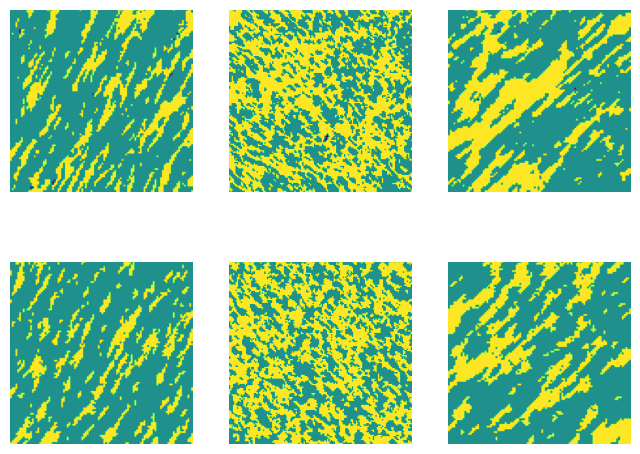

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(8, 6))
for i, key in enumerate(original_files):
    axs[0, i].imshow(original_data[key], vmin=0, vmax=2)
    axs[0, i].axis('off')
    axs[1, i].imshow(1 + data[f'generated_paper_{i+1}'], vmin=0, vmax=2)
    axs[1, i].axis('off')
    
plt.show()

In [11]:
from bitis.texture.properties import DistributionEllipseBuilder, PolarPlots


def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_anisotropy(ax, objects_props, n_std=2):
    objects_props = objects_props[objects_props['area'] >= 5]
    r = objects_props['axis_ratio'].values
    theta = objects_props['orientation'].values

    r = np.concatenate([r, r])
    theta = np.concatenate([theta, theta + np.pi])

    theta = swap_axis(theta)

    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std)
    full_theta = dist_ellipse.full_theta
    orientation = dist_ellipse.orientation
    r, theta, d = PolarPlots.sort_by_density(r, theta)

    ax.scatter(theta, r, c=d, s=30, alpha=1, cmap='viridis')
    ax.plot(full_theta, dist_ellipse.full_radius, color='red')

    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')


def calc_ccdf(df):
    count = np.bincount(df['area'].values.astype(int))
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values.astype(int))
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label=''):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('Fibrotic Tissue')
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label=''):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label)
    ax.set_xlabel('Size')
    ax.set_ylabel('CCDF')
    ax.set_yscale('log')
    ax.set_xscale('log')

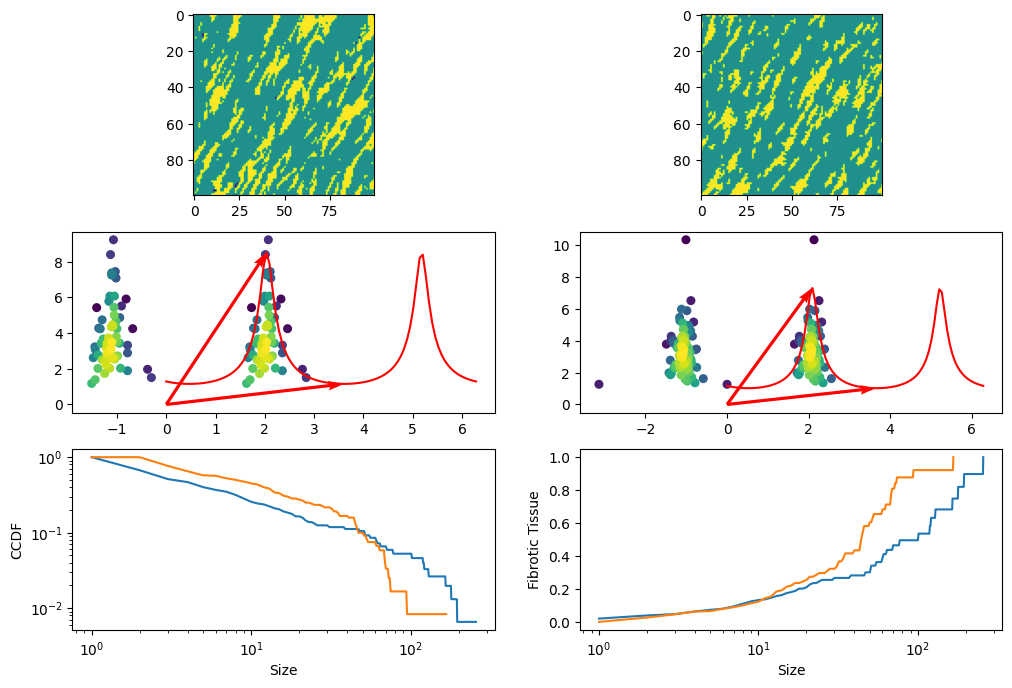

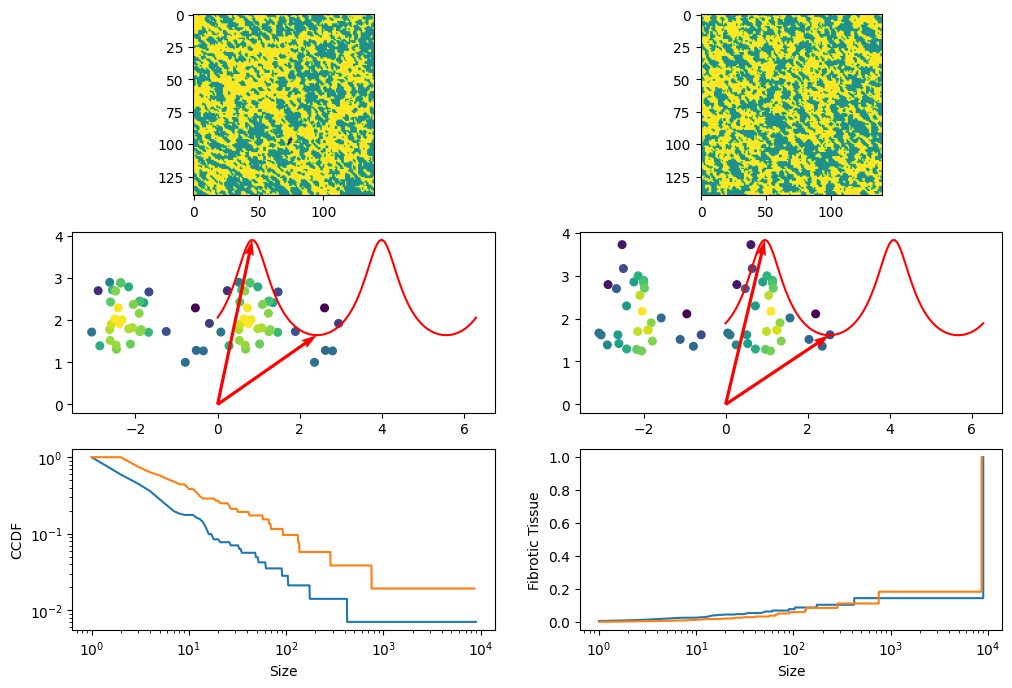

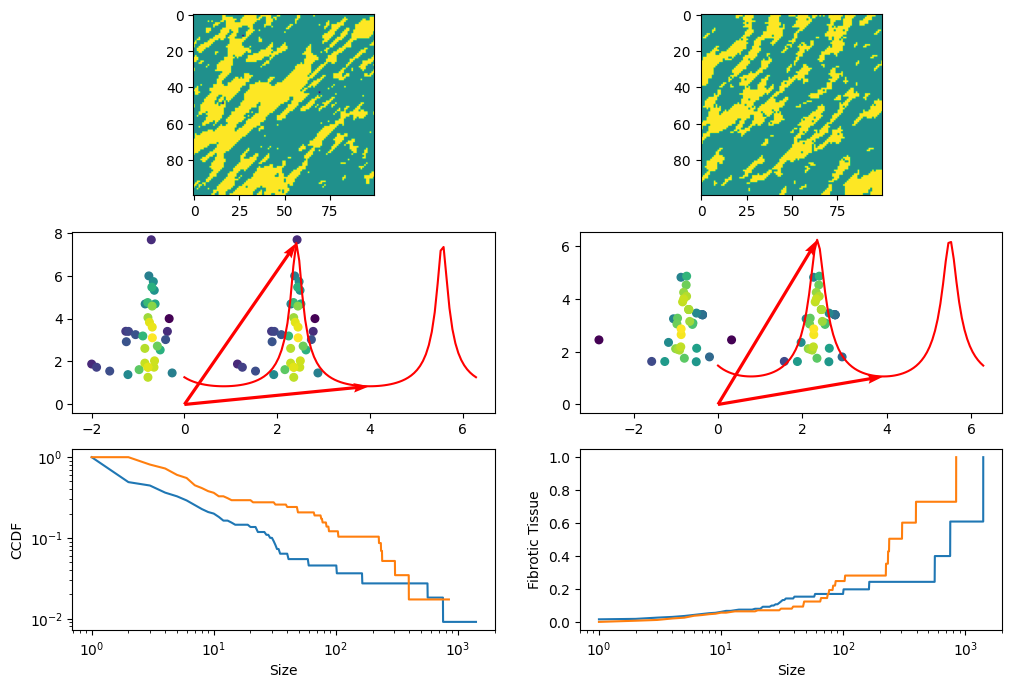

In [15]:
from bitis.texture.properties import PatternPropertiesBuilder


for im_or, im_gen in zip(data_or, data_gen):
    fig = plt.figure()
    axs = fig.subplot_mosaic([['im_or', 'im_gen'],
                              ['anisotropy_or', 'anisotropy_gen'],
                              ['ccdf', 'area_cdf']],
                              per_subplot_kw={('anisotropy_or, anisotropy_or'): dict(projection='polar'),})
    for i, im in enumerate([im_or, im_gen]):
        pattern_builder = PatternPropertiesBuilder(area_quantile=0.95)
        pattern_properties = pattern_builder.build(im == 2)
        obj_props = pattern_builder.object_props

        axs[].imshow(im, vmin=0, vmax=2)
        draw_anisotropy(axs[1, i], obj_props)
        draw_ccdf(axs[2, 0], obj_props)
        draw_area_cdf(axs[2, 1], obj_props)
        
    plt.show()